In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sp 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
import h5py as hdf
from astLib import astCoords as aco
from astLib import astStats as ast
from astLib import astCalc as aca
from numpy.lib import recfunctions as rfns
cosmology.setCosmology('planck18')
import sherpa.astro.ui as ui

# Defining the constants
c=const.c.to("km/s")
%matplotlib inline

# Chosen cosmology
cosmo = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
path_2_data = 'Most_massive_MD04.fits'
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
print(my_file[1].data.columns)
data = my_file[1].data

opening Most_massive_MD04.fits
ColDefs(
    name = 'RA_1'; format = 'E'
    name = 'DEC_1'; format = 'E'
    name = 'g_lat_1'; format = 'E'
    name = 'g_lon_1'; format = 'E'
    name = 'ecl_lat_1'; format = 'E'
    name = 'ecl_lon_1'; format = 'E'
    name = 'redshift_R_1'; format = 'E'
    name = 'redshift_S_1'; format = 'E'
    name = 'dL_1'; format = 'E'
    name = 'nH_1'; format = 'E'
    name = 'ebv_1'; format = 'E'
    name = 'galaxy_SMHMR_mass_1'; format = 'E'
    name = 'galaxy_star_formation_rate_1'; format = 'E'
    name = 'galaxy_is_quiescent_1'; format = 'E'
    name = 'galaxy_LX_hard_1'; format = 'E'
    name = 'galaxy_mag_abs_r_1'; format = 'E'
    name = 'galaxy_mag_r_1'; format = 'E'
    name = 'galaxy_UM_A_UV_1'; format = 'E'
    name = 'galaxy_UM_True_SM_1'; format = 'E'
    name = 'galaxy_UM_ICL_mass_1'; format = 'E'
    name = 'galaxy_UM_True_SFR_1'; format = 'E'
    name = 'galaxy_UM_Obs_UV_1'; format = 'E'
    name = 'HALO_id_1'; format = 'K'
    name = 'HALO_pid

In [5]:
# coordinates of the cluster 
# Redshift at the center of the cluster
z_cl = data.field('redshift_R_1')[0] #
ra_cl = data.field('RA_1')[0]*np.pi/180 # radians
dec_cl= data.field('DEC_1')[0]*np.pi/180 # radians    
r_cl = data.field('HALO_Rvir_1')[0]

# coordinates of the sub haloes
z   = data.field('redshift_R_2') # 
ra  = data.field('RA_2') * (np.pi/180) # degrees
dec = data.field('DEC_2') * (np.pi/180) # degrees

# 3D separation in Mpc, to be verified
r = data.field('separation') # Mpc
 
#Scale radius of the halo
rs=data.field('HALO_rs_2')/1000
rs.max()

0.465257

(array([10., 25., 34., 58., 77., 87., 86., 50., 31., 20.]),
 array([0.3335465 , 0.33363825, 0.33373004, 0.3338218 , 0.3339136 ,
        0.33400536, 0.33409712, 0.3341889 , 0.33428067, 0.33437246,
        0.33446422], dtype=float32),
 <BarContainer object of 10 artists>)

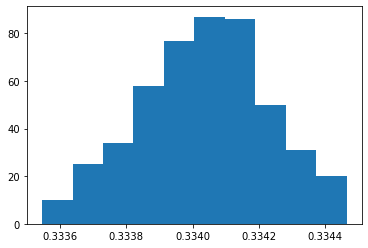

In [51]:
# redshift distribution
plt.hist(z)

In [52]:
# virial radii
r_vir=data.field('HALO_Rvir_2').max()/1000
r_vir

1.9035889892578124

In [53]:
# observed redshift
S1=data.field('redshift_S_2')

# simulated redshift
R1=data.field('redshift_R_2')

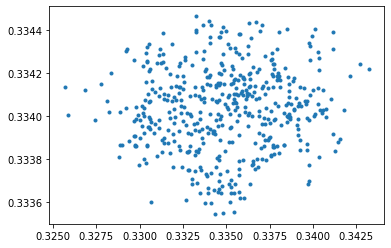

In [54]:
plt.plot(S1,R1,'.')

(array([10., 25., 34., 58., 77., 87., 86., 50., 31., 20.]),
 array([0.3335465 , 0.33363825, 0.33373004, 0.3338218 , 0.3339136 ,
        0.33400536, 0.33409712, 0.3341889 , 0.33428067, 0.33437246,
        0.33446422], dtype=float32),
 <BarContainer object of 10 artists>)

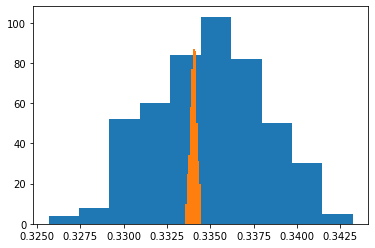

In [55]:
# Redshift distribution
plt.hist(data.field('redshift_S_2')) #observed redshift
plt.hist(data.field('redshift_R_2')) #simulated redshift

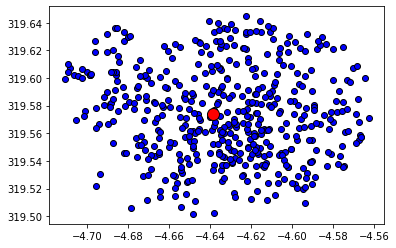

In [11]:
# Projection of the simulated halo
plt.plot(dec*180/np.pi,ra*180/np.pi, color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='blue', markersize=12)
plt.plot(dec_cl*180/np.pi,ra_cl*180/np.pi, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='Red', markersize=12)

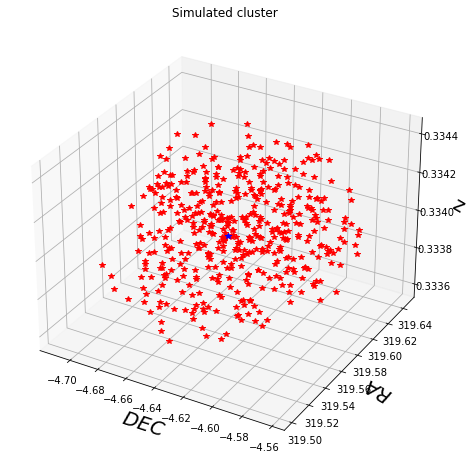

In [63]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.plot3D(dec*180/np.pi,ra*180/np.pi, z,'*',color='red')
ax.plot3D(dec_cl*180/np.pi,ra_cl*180/np.pi, z_cl,'*',color='blue')
ax.set_xlabel('$DEC$', fontsize=20, rotation=150)
ax.set_ylabel('$RA$',fontsize=20, rotation=150)
ax.set_zlabel('z' , fontsize=20, rotation=150)
ax.set_title('Simulated cluster')
plt.show()

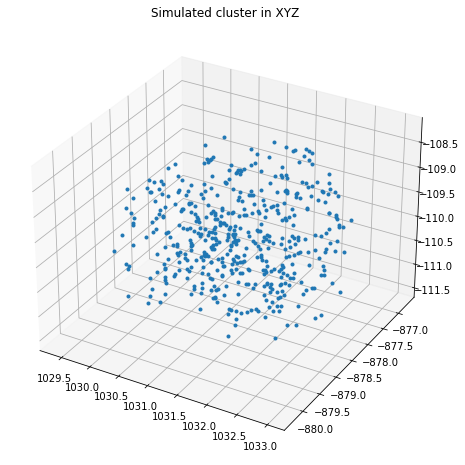

In [62]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.plot3D(x_, y_, z_,'.')

ax.set_title('Simulated cluster in XYZ')


plt.show()

# Projected distance of the cluster

In [14]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra * 180/np.pi, dec * 180/np.pi, unit='deg', frame='icrs') 
coordinate_cluster    = SkyCoord( ra_cl * 180/np.pi, dec_cl*180/np.pi, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)

# Comoving distance
D = cosmo.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj =  (Angular_separation_Astropy_radian * cosmo.angular_diameter_distance(z_cl)/u.radian).value # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max(), 'compared to the 3D virial radius', r_cl/1000)

the cluster at redshift  0.33398816  is at dC= 1359.1182184541588 Mpc
min, max projected distance :  0.0 1.4157164 compared to the 3D virial radius 1.9035889892578124


# 3d radial distance estimation methods

In [15]:
# 3-D distances in between Halo and subhaloes

# comoving distances
D_cl=cosmo.comoving_distance(z).value
D_clus=cosmo.comoving_distance(z_cl).value

def get_x_y_z(ra, dec, D):
    phi   = ( ra*180/np.pi   - 180 ) * np.pi / 180.
    theta = (dec*180/np.pi + 90 ) * np.pi / 180.
    xx = D * np.cos( phi) * np.sin( theta )
    yy = D * np.sin( phi) * np.sin( theta )
    zz = D * np.cos( theta )
    return xx, yy, zz

# get 3D Cartesian positions of the sub haloes
xx, yy, zz = get_x_y_z(ra, dec, D_cl)

# get 3D Cartesian positions of the cluster
xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, D_clus)

# array of distances between sub haloes and the cluster : 
distances = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 ) + (zz_cl-zz)**2
distances.max()

3.7300541966155674

In [16]:
D_cl=cosmo.comoving_distance(z).value
Cord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, distance=D_cl*u.kpc)
r_com=((Cord.cartesian.x)**2 +(Cord.cartesian.y)**2+(Cord.cartesian.z)**2)**0.5
rr=(xx**2 +yy**2+zz**2)**0.5
rr.max(),r_com.max()

(1360.8837940652702, <Quantity 1360.88381971 kpc>)

In [17]:
# the commoving distance formula mentioned in @ https://physics.stackexchange.com/questions/195576/distance-between-two-galaxies-of-different-redshift
commov_sep=np.sqrt((D_cl -D_clus)**2+(4*D_cl*D_clus)*(np.sin\
                                                      (Angular_separation_Astropy_radian.value/2)**2))
commov_sep.max()

1.898509429238217

In [18]:
# distance using astropy function
c1 = SkyCoord(ra_cl*180/np.pi *u.deg, dec_cl*180/np.pi *u.deg, distance=D_cl*u.Mpc, frame='icrs')
c2 = SkyCoord(ra*180/np.pi *u.deg, dec*180/np.pi *u.deg, distance=D_clus*u.Mpc, frame='icrs')
sep = c1.separation_3d(c2)
sep.max()  


<Distance 1.89844748 Mpc>

In [19]:
# distance using the ra and dec by calulating the angle between the objects
x_ =np.array( D_cl * np.cos( dec) * np.cos( ra ))
y_ = np.array(D_cl * np.cos( dec) * np.sin( ra ))
z_ = np.array(D_cl * np.sin( dec ))
x_cl = D_clus * np.cos( dec_cl) * np.cos( ra_cl )
y_cl = D_clus * np.cos( dec_cl) * np.sin( ra_cl )
zcl = D_clus * np.sin( dec_cl )
ui=np.sqrt((x_cl-x_)**2 + (y_cl-y_)**2 + (zcl-z_)**2)
np.max(ui)

1.898779053541235

# Number density profile

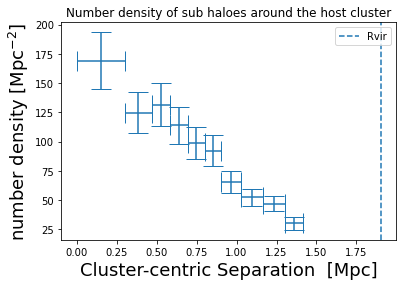

In [21]:
N_subhaloes=len(r_proj)
def get_bins(r_proj, N_per_bin=50):
    dR=0.0001
    
    #choosing the bins
    r_bins_fine = np.arange(0, r_proj.max(), dR)
    
    # Projected distance
    N_2D_fine, bins_2D_fine = np.histogram((r_proj), bins = r_bins_fine)
    R_2D_fine = (bins_2D_fine[1:] + bins_2D_fine[:-1])/2.

    #rint( np.cumsum( N_2D_fine) )
    itp_bins = interp1d(np.cumsum( N_2D_fine), R_2D_fine )
    
    #rint(itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)))
    bins_2D = np.hstack((0., itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)), r_proj.max()))
    #rint(bins_2D)
    
    return bins_2D    

num_points=len(r_proj)


# getting the density profile
bins_2D = get_bins(r_proj, N_per_bin=50)

# Projected distance
N_2D, bins_2D = np.histogram((r_proj), bins = bins_2D)

#Getting the number density profile in 2D 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )
dR_2D = [ bins_2D[1:] - R_2D, R_2D - bins_2D[:-1] ]
error=np.sqrt(len(r_proj)) / len(r_proj) *N_2D /np.pi*(  bins_2D[1:]**2 - bins_2D[:-1]**2)

               
# central point of each separation 

plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='',capsize=10)
#plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D[0], ls='')

plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=r_cl/1000.,linestyle='dashed',label = 'Rvir')
#plt.yscale('log')
#plt.xscale('log')
plt.legend(loc=1, numpoints=1)
plt.show()


In [22]:
def poiss_err(n, alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in 
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3
    :param: alpha corresponds to central confidence level 1-alpha, 
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = sp.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = sp.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

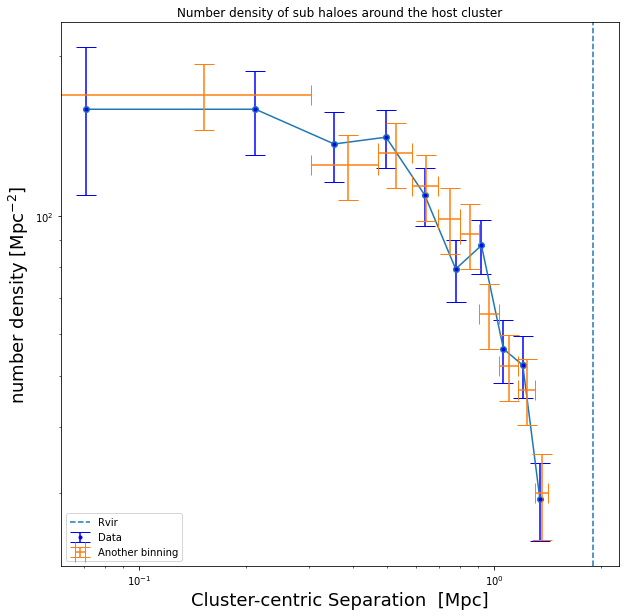

In [24]:
# another attempt to get the number density profile
nbins=10
n_data,R_bins=np.histogram(r_proj, nbins, range=(r_proj.min(), r_proj.max()))
# ignore bin with zero count
select = n_data > 0 
n_data = n_data[select]
R_bins_low = R_bins[:-1][select]
R_bins_high = R_bins[1:][select]

# compute poisson error  errors in n_data
n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
R_bins_ce = 0.5 * (R_bins_low + R_bins_high)

# light profile
delta_R2 = (R_bins_high**2 - R_bins_low**2)
Sig_data = n_data / (np.pi * delta_R2)
Sig_data_low = n_data_low / (np.pi * delta_R2)
Sig_data_high = n_data_high / (np.pi * delta_R2), 

# error
sig_low = Sig_data - Sig_data_low
sig_high = Sig_data_high - Sig_data

# plotting
plt.figure(0, (10, 10))
plt.errorbar((R_bins_ce), Sig_data,yerr=(Sig_data - Sig_data_low), 
    color='blue',  fmt='.', capsize=10, label='Data')
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, capsize=10,ls='',label='Another binning')
#plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D[0], ls='')

plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=r_cl/1000.,linestyle='dashed',label = 'Rvir')
plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.show()

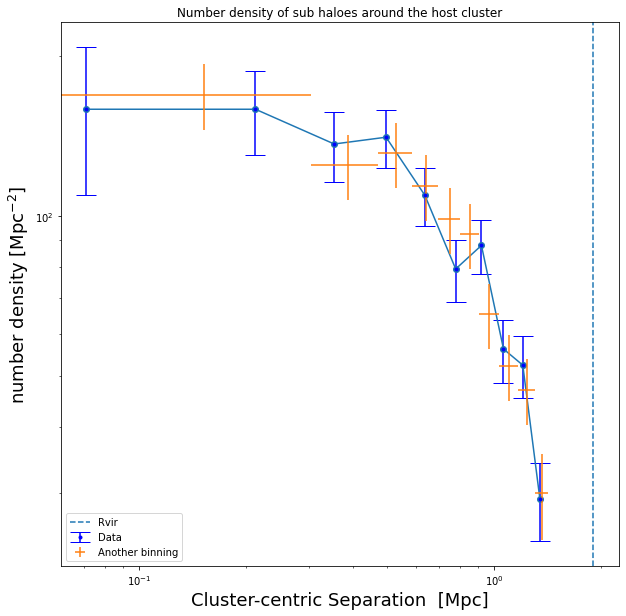

In [25]:
# plotting
plt.figure(0, (10, 10))
plt.errorbar((R_bins_ce), Sig_data,yerr=(Sig_data - Sig_data_low), 
    color='blue',  fmt='.', capsize=10, label='Data')
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='',label='Another binning')
#plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D[0], ls='')

plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=r_cl/1000.,linestyle='dashed',label = 'Rvir')
plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.show()

#   $ n(R)= \frac{N}{{\pi}(Rout^2-Rin^2)} $

# Number density profile 

# $\nu(r)= \frac{4}{3}{{\pi}(rout^3-rin^3)} $



In [26]:
# similarly  for 3d distance
N_subhaloes=len(r)
def get_bins(r_proj, N_per_bin=50):
    dR=0.0001

    #choosing the bins
    r_bins_fine = np.arange(0, r.max(), dR)

    # Projected distance
    N_3D_fine, bins_3D_fine = np.histogram(np.array(r), bins = r_bins_fine)
    R_3D_fine = (bins_3D_fine[1:] + bins_3D_fine[:-1])/2.

    #rint( np.cumsum( N_2D_fine) )
    itp_bins = interp1d(np.cumsum( N_3D_fine), R_3D_fine )

    #rint(itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)))
    bins_3D = np.hstack((0., itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)), r.max()))
    #rint(bins_2D)

    return bins_3D
# getting the bins
# Three D distance
bins_3D = get_bins(r, N_per_bin=50)
N_3D, bins_3D = np.histogram(r, bins = bins_3D)

R_3D = (bins_3D[1:] + bins_3D[:-1])/2.
dR_3D = [ bins_3D[1:] - R_3D, R_3D - bins_3D[:-1] ]

#Ns,rs=np.histogram(r)
n_3D = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))
error1=np.sqrt(len(r)) / len(r) *N_3D /np.pi*(  bins_3D[1:]**2 - bins_3D[:-1]**2)

array([32.92571397, 24.9886142 , 21.83896386, 19.65335097, 17.71633642,
       16.06090184, 14.78195795, 13.68149255, 12.61308422, 11.86230579])

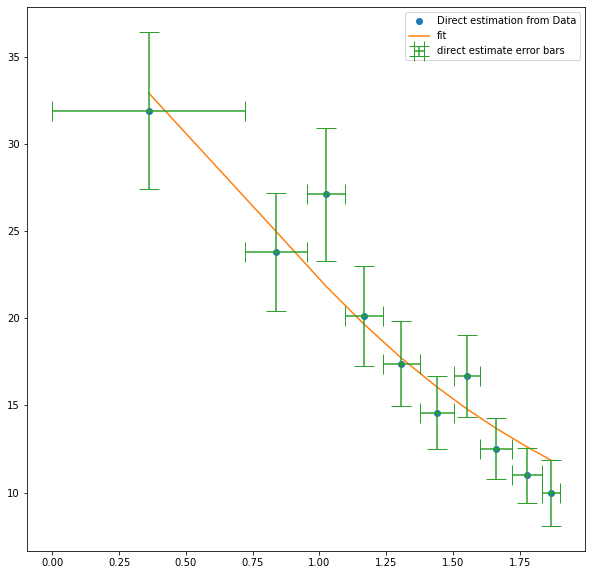

In [27]:
# Beta /SIS alternative model, if NFW doesn't works 
def Beta_nu(r,rhos,rs):
    return rhos / (1.0 + (r/rs)** 2)**0.9

#Curve fit
parameters, covariance = curve_fit(Beta_nu,R_3D, n_3D)
fit_A=parameters[0]
fit_B=parameters[1]
#fit_c=parameters[2]

#plot
fit_y = Beta_nu(R_3D, fit_A, fit_B)
plt.figure(0, (10, 10))
plt.plot(R_3D, n_3D, 'o', label='Direct estimation from Data')
plt.plot(R_3D, fit_y, '-', label='fit')
plt.errorbar(R_3D, n_3D, xerr=dR_3D, ls='', yerr=n_3D * N_3D**-0.5,capsize=10, label='direct estimate error bars')
#plt.errorbar(r_act, n_3D, xerr=error1, ls='', yerr=n_3D * N_3D**-0.5, label='direct estimate error bars')

plt.legend()
fit_y

[]

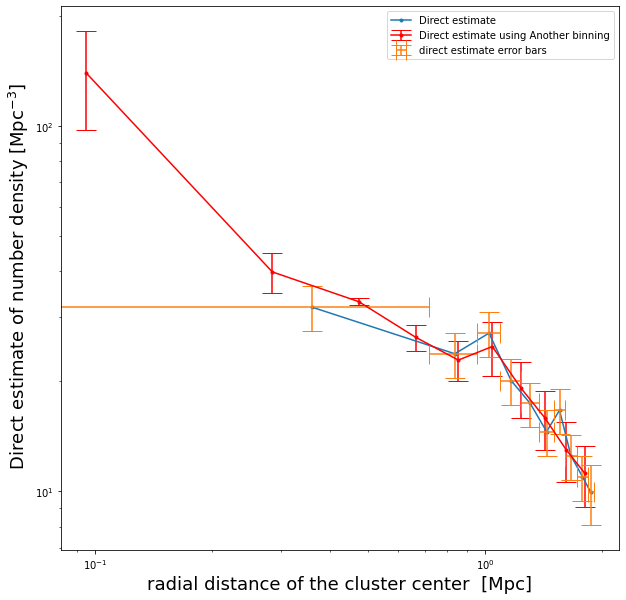

In [28]:
nbins=10
n_data,R_bins=np.histogram(r, nbins, range=(r.min(), r.max()))
# ignore bin with zero count
select = n_data > 0 
n_data = n_data[select]
R_bins_low = R_bins[:-1][select]
R_bins_high = R_bins[1:][select]
# compute poisson error  errors in n_data
n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
r_mid = 0.5 * (R_bins_low + R_bins_high)

# light profile
delta_R2 = (R_bins_high**3 - R_bins_low**3)
number_density = n_data /(4/3* (np.pi * delta_R2))
n_den_low = n_data_low / (np.pi * delta_R2)
n_den_high = n_data_high / (np.pi * delta_R2), R_bins_ce

# error
sig_low = number_density - n_den_low
sig_high =n_den_high - number_density
#return R_bins_low,R_bins_high,n_data_low, n_data_high, Sig_data, Sig_data_high, Sig_data_low

plt.figure(0, (10, 10))
plt.errorbar((r_mid), number_density,yerr=(number_density - n_den_low),color='red', 
             fmt= '.', capsize=10,label='Direct estimate using Another binning',linestyle='-')
plt.plot(R_3D,n_3D,'.',linestyle='-',label='Direct estimate')
plt.errorbar(R_3D, n_3D, xerr=dR_3D, ls='', yerr=n_3D * N_3D**-0.5,capsize=10, label='direct estimate error bars')

plt.xlabel('radial distance of the cluster center  [Mpc]',fontsize=18)
plt.ylabel(r' Direct estimate of number density [Mpc$^{-3}$]',fontsize=18) 
plt.legend()
plt.loglog()

In [29]:
R_3D ,R_bins_high

(array([0.360275  , 0.8368    , 1.0243    , 1.1667    , 1.30615   ,
        1.439     , 1.553     , 1.66115   , 1.7772    , 1.86665476]),
 array([0.18987595, 0.3797519 , 0.56962785, 0.75950381, 0.94937976,
        1.13925571, 1.32913166, 1.51900761, 1.70888356, 1.89875952]))

Getting the deprojection profile from inversion equation 
# $\nu(r)= -\frac{1}{\pi}  {\int_{r}^\infty} \frac{dn}{dR}  \frac{dR}{\sqrt{R^2-r^2}}$

In [30]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R)/((R**2 - r**2)**0.5))
    
    nu_all=np.array([integrate.quad(nu, r_i, 1.90, args=(r_i))[0] for r_i in R_3D])
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)
nu_all

/tmp/ipykernel_18347/3128422171.py:31: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=np.array([integrate.quad(nu, r_i, 1.90, args=(r_i))[0] for r_i in R_3D])


array([70.03800479, 60.88755023, 43.7468079 , 38.38843022, 38.32109703,
       33.20548597, 27.67872898, 22.1465718 , 15.29907634,  7.75457678])

In [32]:
#Getting the derivative term of n wrt R_proj  ie dndR
dndR_ = np.array(np.gradient(Sig_data,R_bins_ce))
n_2D_no0 = n_data
n_2D_no0[n_data==0] = 1

dndR_up_ = np.array(np.gradient( Sig_data + Sig_data * n_2D_no0**-0.5, R_bins_ce ))
dndR_low_ = np.array(np.gradient( Sig_data - Sig_data * n_2D_no0**-0.5, R_bins_ce ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_bins_ce), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from
    # 2D to 3D using the Abel inversion equation

    def nu(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R)/((R**2 - r**2)**0.5))

    nu_all_diff=np.array([integrate.quad(nu, r_i, 1.90, args=(r_i))[0] for r_i in R_bins_high])
    return nu_all_diff

nu_all_diff = get_nu_all(dndR_)
nu_all_up_ = get_nu_all(dndR_up_)
nu_all_low_ = get_nu_all(dndR_low_)
nu_all_diff

/tmp/ipykernel_18347/2546587887.py:26: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all_diff=np.array([integrate.quad(nu, r_i, 1.90, args=(r_i))[0] for r_i in R_bins_high])


array([96.25902181, 84.1391808 , 84.66658222, 55.53145623, 52.71166003,
       46.95661131, 45.31437117, 34.75167056, 23.09931425,  1.75409059])

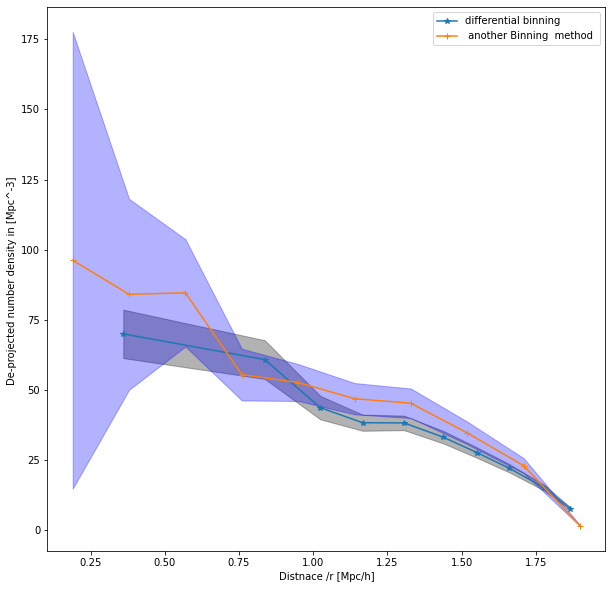

In [33]:
plt.figure(0, (10, 10))
plt.plot(R_3D,nu_all,'*',linestyle='-', label='differential binning')
plt.plot(R_bins_high,nu_all_diff,'+',linestyle='-',label= ' another Binning  method ')
plt.fill_between(R_3D, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')
plt.fill_between(R_bins_high, y1=nu_all_low_, y2=nu_all_up_, alpha=0.3, color='blue')


plt.xlabel('Distnace /r [Mpc/h]')
plt.ylabel('De-projected number density in [Mpc^-3] ')
plt.legend()
plt.show()


# Determination of velocity dispersion

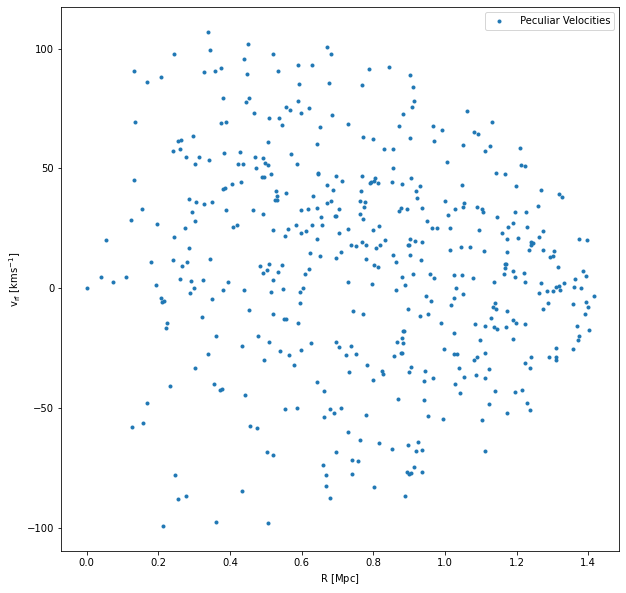

In [34]:
# Phase space distribution of the subhaloes
c=const.c.to("km/s")
los_v= (c*(z - z_cl)/(1 + z_cl)).value
los_v

#Plotting the phase space distribution of the rest frame velocities wrt the radial distances
plt.figure(0, (10, 10))
plt.plot(r_proj,los_v, '.' ,label=" Peculiar Velocities") 
plt.xlabel("$\mathrm{R~[Mpc]}$")
plt.ylabel("$\mathrm{v_{rf}~[kms^{-1}]}$")
plt.legend()


In [35]:
from astroML.density_estimation import bayesian_blocks

def velocity_dispersion_profile(r_proj, los_v):
    # compute the optimal bin edges using Bayesian Blocks method
    bin_edges = bayesian_blocks(r_proj)
    bin_indices = np.digitize(r_proj, bin_edges)

    velocity_dispersion_profile = []
    radial_diff = []
    for i in range(1, len(bin_edges)):
        bin_galaxies = los_v[bin_indices == i]
        mean_velocity = np.mean(bin_galaxies)
        velocity_dispersion = np.std(bin_galaxies)
        radial_diff.append([bin_edges[i]])
        velocity_dispersion_profile.append([ velocity_dispersion])

    return velocity_dispersion_profile,radial_diff
velocity_dispersion_profile(r_proj, los_v)

        Use astropy.stats.bayesian_blocks instead. [warnings]
        Use astropy.stats.Events instead. [astroML.density_estimation.bayesian_blocks]
        Use astropy.stats.FitnessFunc instead. [astropy.utils.decorators]


([[41.408443], [43.634346]], [[0.20735816657543182], [1.4157164096832275]])

In [36]:
#three different estimation based on the paper @https://articles.adsabs.harvard.edu/pdf/1990AJ....100...32B
# @https://arxiv.org/abs/2006.05949
# power law to fit the profile
def sigma_v(r,v_0,beta):
    
    return v_0 / (1+ r) ** beta

# biweight estimates of the velocity dispersion
def biweight_vdisp(v):
    
    if v.size > 2:
        sigma = biweight_scale(v, 9)
        return sigma
    
def biweight_est_error(v):
    sigma_err = 0.92 * sigma / (np.sqrt(v.size - 1))
    return sigma_err

def gapper_vdisp(v):
   
    v = np.sort(v)
    n = len(v)
    w = np.arange(1, n) * np.arange(n - 1, 0, -1)
    g = np.diff(v)
    return (np.sqrt(np.pi)) / (n * (n - 1)) * np.sum(w * g)

def sigma_std(v):
    return np.std(v)

def avg_vel(v):
    return np.sqrt(np.average((los_v**2)))

# sigma and the error
sigma =  biweight_scale(los_v)
sigma_err = 0.92 * sigma / (np.sqrt(los_v.size - 1))
sigma,sigma_err,biweight_vdisp(los_v),gapper_vdisp(los_v),sigma_std(los_v),avg_vel(los_v)

(44.67290785120936,
 1.8817973834721136,
 44.67290785120936,
 43.9275284856896,
 43.518856,
 44.698826)

In [37]:
# binned_dispersion
def binned_dispersion(x, y, nbins, method="mad"):

    d, N, mean = [np.zeros(nbins) for i in range(3)]
    bin_width = (max(x) - min(x))/nbins
    left_bin_edges = np.array([min(x) + i*bin_width for i in range(nbins)])
    right_bin_edges = left_bin_edges + bin_width
    mid_bin = left_bin_edges + .5*bin_width

    for i in range(nbins):
        m = (left_bin_edges[i] < x) * (x < right_bin_edges[i])
        mean[i] = np.mean(y[m])
        N[i] = sum(m)
        if method == "std":
            d[i] = np.std(y[m])
        elif method == "mad":
    #d[i] = np.median(np.abs(y[m]))
            d[i] = np.sqrt(np.median(y[m]))
        elif method == "sd":
            d[i] = sigma_std(y[m])
        elif method == "rms":
            d[i] = np.sqrt(np.mean((y[m])**2))
        elif method == "biweight":
            d[i] = biweight_vdisp((y[m]))
        elif method == "average":
            d[i] = avg_vel((y[m]))
    return mid_bin, d, d/np.sqrt(N), mean


(array([10., 25., 34., 58., 77., 87., 86., 50., 31., 20.]),
 array([-99.258354 , -78.63378  , -58.00921  , -37.384636 , -16.760063 ,
          3.8645096,  24.489082 ,  45.113655 ,  65.73823  ,  86.3628   ,
        106.98737  ], dtype=float32),
 <BarContainer object of 10 artists>)

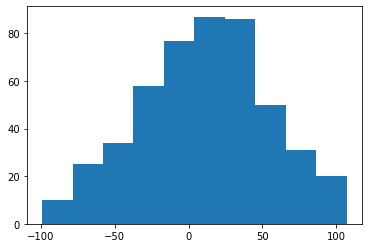

In [38]:
# velocity distribution
plt.hist(los_v)

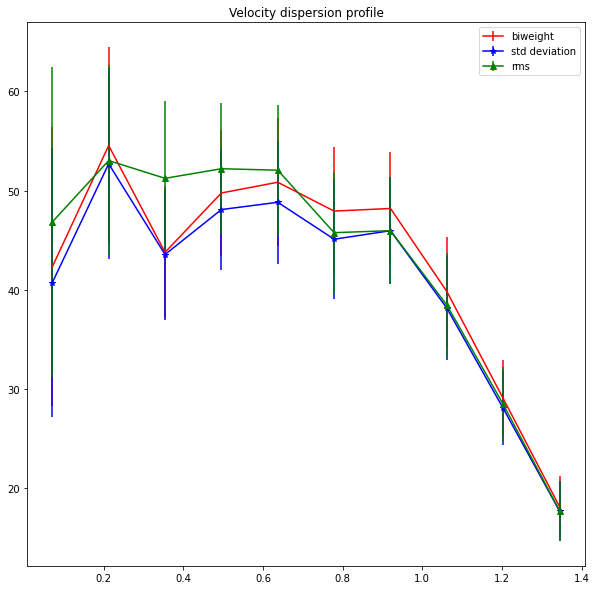

In [39]:
n_bin=10
# getting the profile
proj_dist, los_disp, err, mean = binned_dispersion(r_proj, los_v, n_bin, method="biweight")
proj_dist1, los_disp1, err1, mean1 =binned_dispersion(r_proj, los_v, n_bin, method="std")
proj_dist2, los_disp2, err2, mean2 =binned_dispersion(r_proj, los_v, n_bin, method="rms")
#bins3, dbins3, err3, mean3 =binned_dispersion(r_proj, los_v, n_bin, method="sd")
#bins4, dbins4, err4, mean4 =binned_dispersion(r_proj, los_v, n_bin, method="average")


#plotting the Velocity dispersion profile
plt.figure(0, (10, 10))
plt.title("Velocity dispersion profile")
plt.errorbar(proj_dist, los_disp, yerr=err,color='red',   label="biweight",linestyle='-')
plt.errorbar(proj_dist1, los_disp1, yerr=err1,color='blue', fmt="*",  label="std deviation",linestyle='-')
plt.errorbar(proj_dist2, los_disp2, yerr=err2,color='green', fmt="^", label="rms",linestyle='-')
#plt.errorbar(bins3, dbins3, yerr=err3,color='black', fmt=".", label="sd",linestyle='-')
##plt.errorbar(bins4, dbins4, yerr=err4,color='Yellow', fmt="+", label="average",linestyle='-')

plt.legend()

In [40]:
nvd= n_2D*(los_disp2**2) 
# deprojecting the line of sight  velocity dispersion

dndV=np.array(np.gradient(nvd,R_2D))

def get_sigma_all(dndV):
    aa = np.hstack((np.array([0]),np.array(R_2D), np.array([2.]) ))
    bb = np.hstack((np.array(dndV[0]),np.array(dndV), np.array([0.]) ))

    # getting the interpolation
    interp1 = interp1d(aa, bb, bounds_error=True)

    # De-projection of the line of sight velocity profile from 
    # 2D to 3D using the Abel inversion equation

    def sigma(R, r):
        
        return -1/(np.pi)*(interp1(R)/((R**2 - r**2)**0.5))
     
    sigma_all=np.array([integrate.quad(sigma, r_i, 1.90, args=(r_i))[0] for r_i in np.sort(R_bins_high)])
    return sigma_all

sigma_all =(get_sigma_all(dndV))
sigma_all

/tmp/ipykernel_18347/2341545407.py:20: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sigma_all=np.array([integrate.quad(sigma, r_i, 1.90, args=(r_i))[0] for r_i in np.sort(R_bins_high)])


array([184894.09326616, 180154.25921635, 204573.0228118 , 197953.3592622 ,
       130332.47219435,  79069.13799593,  49806.03099488,  28391.06443139,
        12267.59325639,    418.65205458])

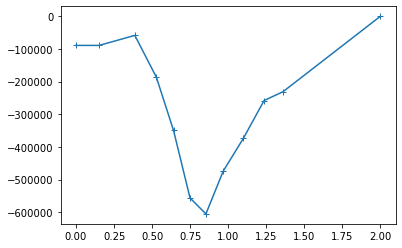

In [41]:
aa = np.hstack((np.array([0]),np.array(R_2D), np.array([2.]) ))
bb = np.hstack((np.array(dndV[0]),np.array(dndV), np.array([0.]) ))
plt.plot(aa,bb,'+',linestyle='-')

array([51.3800634 , 54.39487921, 68.38344829, 71.80939395, 58.31863494,
       48.79761338, 42.41972958, 35.80449753, 28.3169894 ,  7.34763482])

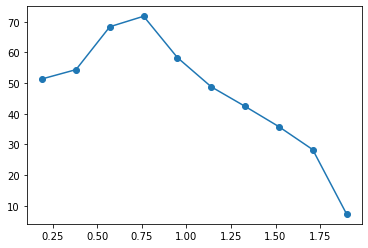

In [42]:
vd_r=np.sqrt((sigma_all)/(nu_all))
plt.plot(R_bins_high,vd_r,'o',linestyle= '-')
vd_r

In [43]:
def r_200(v,z_cl):
    return np.sqrt(3) *v /(10*aca.H0 * aca.Ez(z_cl))
    
r_200(910,z_cl)

1.8946195160855923

In [44]:
#finding the slop

# logarithmic derivative of the density profile
dln_nu=R_bins_high /nu_all *(np.gradient(nu_all,R_bins_high))

#logarithmic derivetive of the velocity dispersion
dln_sigma=R_bins_high/vd_r*(np.gradient(vd_r,R_bins_high))


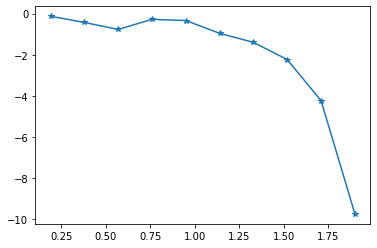

In [45]:
plt.plot(R_bins_high,dln_nu,'*',linestyle='-')


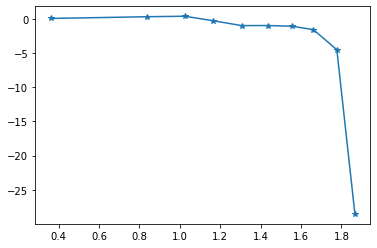

In [46]:
plt.plot(R_3D,dln_sigma,'*',linestyle='-')

In [67]:
cluster_vel=280
#evaluate cluster mass
vel_disp=cluster_vel*10**3 # Km to meters
radius=(r_cl/1000)*3.086e+22 # 1.1 Mpc      # maximum distance from the cluster's centre
M=-(vel_disp**2)*radius/(const.G).value *5.0279e-31   *(dln_nu +dln_sigma) #converted into solar masses unless the unit remains the sane
M

array([2.49710143e+12, 4.13589907e+12, 1.35124628e+13, 1.95330581e+13,
       4.59566944e+13, 6.72714112e+13, 8.57122985e+13, 1.32238928e+14,
       3.03768840e+14, 1.32770613e+15])

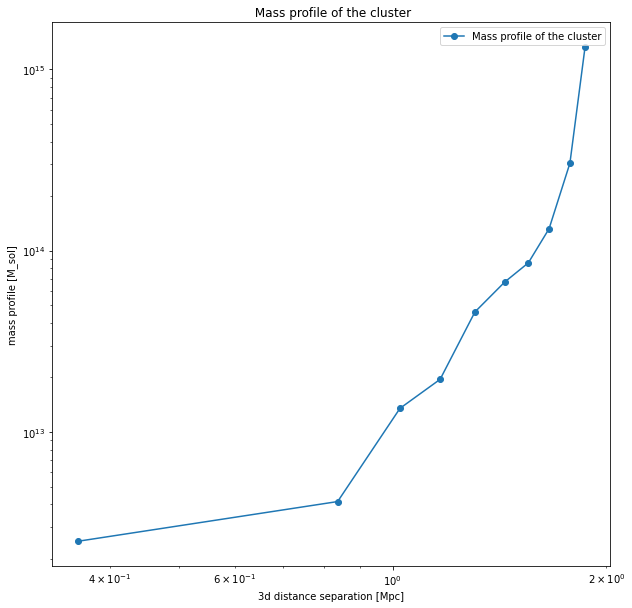

In [68]:
plt.figure(0, (10, 10))
plt.title(' Mass profile of the cluster')
plt.plot(R_3D,M,'o',linestyle='-',label='Mass profile of the cluster')
plt.xlabel('3d distance separation [Mpc]')
plt.ylabel('mass profile [M_sol]')
plt.loglog()
plt.legend()
plt.show()

In [49]:
data.field('HALO_Mvir_1')[0]/1e14

9.14711533060096